# Data Exploration

This notebook demonstrates how to read a video file, extract frames, and display them using OpenCV and Matplotlib. It also shows how to detect faces in a frame using the Viola-Jones algorithm.

In [1]:
import cv2

input_video_path = '/Volumes/Patrick/Datasets/VitalCamSet/Proband16/101_natural_lighting/Logitech HD Pro Webcam C920.avi'
video = cv2.VideoCapture(input_video_path)

## Video properties

In [2]:
# Get the video properties
fps = video.get(cv2.CAP_PROP_FPS)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = frame_count / fps

print(f'FPS: {fps}')
print(f'Frame count: {frame_count}')
print(f'Frame: {frame_width}x{frame_height}')
print(f'Duration: {duration:.2f} seconds')

FPS: 30.0
Frame count: 3600
Frame: 640x480
Duration: 120.00 seconds


## Display random frames

In [3]:
import random

# Seed the random number generator for reproducibility
random.seed(42)

frame_inx1 = 405
frame_inx2 = 415
# frame_inx1 = random.randint(0, frame_count)
# frame_inx2 = random.randint(0, frame_count)

video.set(cv2.CAP_PROP_POS_FRAMES, frame_inx1)
_, frame1 = video.read()

video.set(cv2.CAP_PROP_POS_FRAMES, frame_inx2)
_, frame2 = video.read()

Text(0.5, 1.0, 'Frame 415')

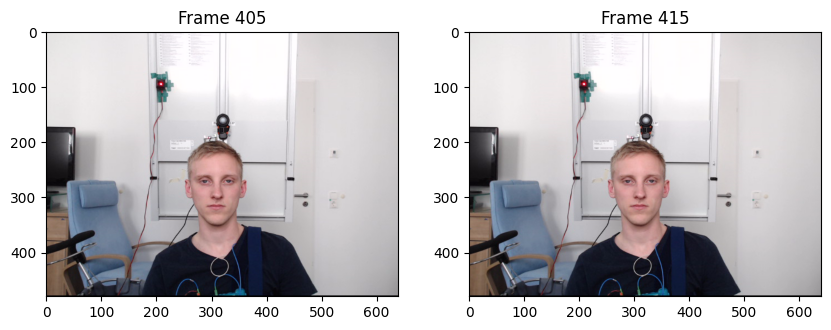

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
axes[0].imshow(frame1)
axes[0].set_title(f'Frame {frame_inx1}')

frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
axes[1].imshow(frame2)
axes[1].set_title(f'Frame {frame_inx2}')

## Optical flow

In [5]:
import respiration.utils as utils

device = utils.get_torch_device();

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [7]:
import respiration.dataset as dt

dataset = dt.from_default()

In [26]:
import torch

frame1_ts = torch.tensor(frame1, device=device, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
frame2_ts = torch.tensor(frame2, device=device, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

In [27]:
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
        ]
    )
    return transforms(batch).to(device)

frame1_ts = preprocess(frame1_ts)
frame2_ts = preprocess(frame2_ts)

Text(0.5, 1.0, 'Frame 2')

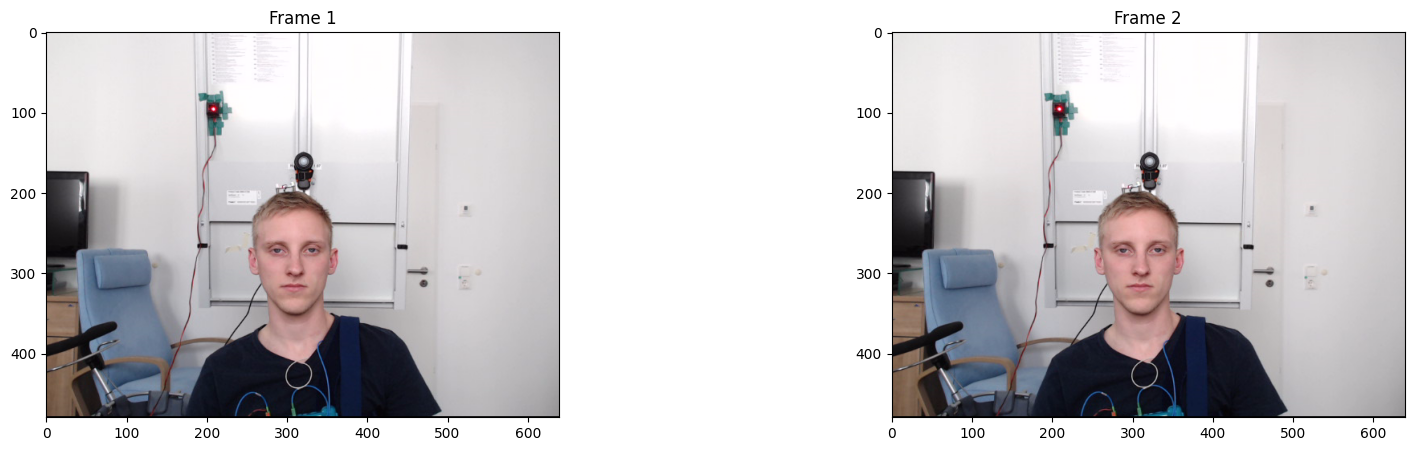

In [28]:
# Display the normalized frames
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

img_1 = frame1_ts.permute(1, 2, 0).cpu().detach().numpy()
img_1 = (img_1 - img_1.min()) / (img_1.max() - img_1.min())
axes[0].imshow(img_1)
axes[0].set_title('Frame 1')

img_2 = frame2_ts.permute(1, 2, 0).cpu().detach().numpy()
img_2 = (img_2 - img_2.min()) / (img_2.max() - img_2.min())
axes[1].imshow(img_2)
axes[1].set_title('Frame 2')

In [29]:
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights

model = raft_large(
    weights=Raft_Large_Weights.C_T_SKHT_V2,
    progress=True,
).to(device)
model = model.eval()

image1 = frame1_ts.unsqueeze(0)
image2 = frame2_ts.unsqueeze(0)

list_of_flows = model(image1, image2)
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [30]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([1, 2, 480, 640]) = (N, 2, H, W)
min = -1861.34619140625, max = 1750.646240234375


In [31]:
# Get a random flow vector
predicted_flows[0, :, 120, 120]

tensor([ 1457.0989, -1605.4890], device='mps:0', grad_fn=<SelectBackward0>)

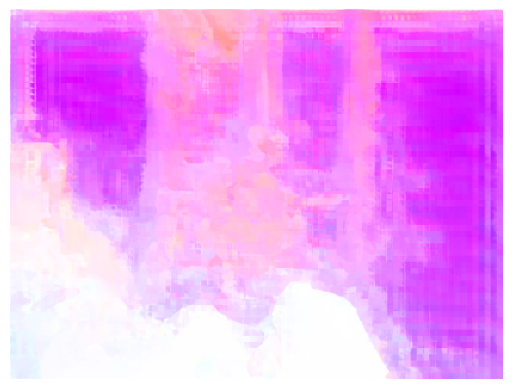

In [32]:
from torchvision.utils import flow_to_image, make_grid

flow_imgs = flow_to_image(predicted_flows.to("cpu"))

plt.axis("off")
plt.imshow(make_grid(flow_imgs, nrow=2).permute(1, 2, 0))
plt.show()

In [33]:
def draw_flow(img, flow, step=40):
    """
    Plots the optical flow vectors on the image.
    Args:
    - img: The original image.
    - flow: The optical flow vectors (HxWx2).
    - step: Space between vectors to be drawn.
    """

    h, w = img.shape[:2]
    y, x = np.mgrid[step // 2:h:step, step // 2:w:step].reshape(2, -1).astype(int)
    fx, fy = flow[y, x].T

    # Create an image to draw on
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw arrows
    for (x0, y0, dx, dy) in zip(x, y, fx, fy):
        # Length of the arrow is sqrt(dx^2 + dy^2)
        # length = np.sqrt(dx ** 2 + dy ** 2)
        # if length > 20:
        #     continue

        end_point = (int(x0 + dx), int(y0 + dy))
        cv2.arrowedLine(
            vis,
            (x0, y0),
            end_point,
            color=(255, 0, 0),
            thickness=1,
            tipLength=0.25,
        )

    return vis


def draw_flow_max(img, flow):
    """
    Plots the optical flow vectors on the image.
    Args:
    - img: The original image.
    - flow: The optical flow vectors (HxWx2).
    """

    h, w = img.shape[:2]
    fx, fy = flow[:, :, 0], flow[:, :, 1]

    # Create an image to draw on
    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw arrows
    for y in range(h):
        for x in range(w):
            dx, dy = fx[y, x], fy[y, x]
            end_point = (int(x + dx), int(y + dy))

            # Length of the arrow is sqrt(dx^2 + dy^2)
            length = np.sqrt(dx ** 2 + dy ** 2)
            if length > 20:
                continue

            cv2.arrowedLine(
                vis,
                (x, y),
                end_point,
                color=(255, 0, 0),
                thickness=1,
                tipLength=0.25,
            )

    return vis

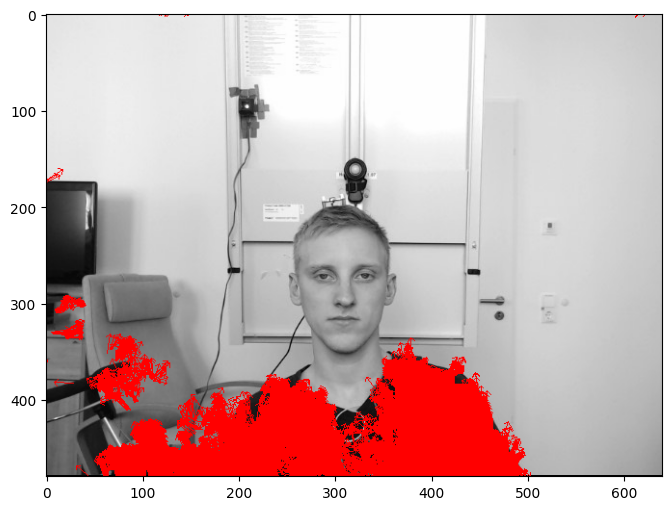

In [35]:
# Convert the frame to grayscale
frame1_gray = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)

# Draw the optical flow vectors on the frame
flow_img = draw_flow_max(frame1_gray, predicted_flows[-1].permute(1, 2, 0).cpu().detach().numpy())

# Display the frame with the optical flow vectors
plt.figure(figsize=(20, 6))
plt.imshow(flow_img)
plt.show()